In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import joblib
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
dataset = pd.read_excel(r"C:\Users\NT551\Desktop\날짜별 깃 업데이트 모음\06.19\dataset_draft5_2.xlsx", index_col=0, dtype = {"gameId": "str"})
dataset.info()

# 레이블 인코딩
label_encoder = LabelEncoder()
dataset["winner"] = label_encoder.fit_transform(dataset["winner"])

# 데이터 전처리
dropped_dataset = dataset.drop(["gameId"], axis=1)
desired_X_column_list = list(dropped_dataset.columns)
desired_X_column_list.remove("winner")
dropped_dataset.drop_duplicates(subset=desired_X_column_list, inplace=True)

y = dropped_dataset["winner"]
X = dropped_dataset.drop(["winner"], axis=1)

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


<class 'pandas.core.frame.DataFrame'>
Index: 6884 entries, 0 to 6883
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gameId                     6884 non-null   object 
 1   Blue_Adc_assistsPerTime    6884 non-null   float64
 2   Blue_Adc_deathsPerTime     6884 non-null   float64
 3   Blue_Adc_killsPerTime      6884 non-null   float64
 4   Blue_Jgl_assistsPerTime    6884 non-null   float64
 5   Blue_Jgl_deathsPerTime     6884 non-null   float64
 6   Blue_Jgl_killsPerTime      6884 non-null   float64
 7   Blue_Mid_assistsPerTime    6884 non-null   float64
 8   Blue_Mid_deathsPerTime     6884 non-null   float64
 9   Blue_Mid_killsPerTime      6884 non-null   float64
 10  Blue_Spt_assistsPerTime    6884 non-null   float64
 11  Blue_Top_assistsPerTime    6884 non-null   float64
 12  Blue_Top_deathsPerTime     6884 non-null   float64
 13  Blue_Top_killsPerTime      6884 non-null   float64
 1

In [19]:
# 레이블 인코딩
label_encoder = LabelEncoder()
dataset["winner"] = label_encoder.fit_transform(dataset["winner"])

In [20]:
# 데이터 전처리
dropped_dataset = dataset.drop(["gameId"], axis=1)
desired_X_column_list = list(dropped_dataset.columns)
desired_X_column_list.remove("winner")
dropped_dataset.drop_duplicates(subset=desired_X_column_list, inplace=True)
y = dropped_dataset["winner"]
X = dropped_dataset.drop(["winner"], axis=1)

In [21]:
# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [22]:
# XGBoost 하이퍼파라미터 그리드 정의
xgb_param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.3, 0.7]
}

# XGBoost 그리드 서치
xgb_grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                               param_grid=xgb_param_grid,
                               scoring='neg_mean_squared_error',
                               cv=3,
                               verbose=1)
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")

# LightGBM 하이퍼파라미터 그리드 정의
lgb_param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.9, 1.0]
}

# LightGBM 그리드 서치
lgb_grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(),
                               param_grid=lgb_param_grid,
                               scoring='neg_mean_squared_error',
                               cv=3,
                               verbose=1)
lgb_grid_search.fit(X_train, y_train)
lgb_best_model = lgb_grid_search.best_estimator_
print(f"Best LightGBM parameters: {lgb_grid_search.best_params_}")

# RandomForest 하이퍼파라미터 그리드 정의
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# RandomForest 그리드 서치
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=rf_param_grid,
                              scoring='neg_mean_squared_error',
                              cv=3,
                              verbose=1)
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
print(f"Best RandomForest parameters: {rf_grid_search.best_params_}")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best XGBoost parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Number of positive: 1738, number of negative: 1931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17180
[LightGBM] [Info] Number of data points in the train set: 3669, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473699 -> initscore=-0.105303
[LightGBM] [Info] Start training from score -0.105303
[LightGBM] [Info] Number of positive: 1738, number of negative: 1931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17173
[LightG

In [23]:
# 베이스 모델 리스트
base_models = [
    ('xgb', xgb_best_model),
    ('lgb', lgb_best_model),
    ('rf', rf_best_model)
]

# 메타 모델 정의
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 스태킹 모델 정의
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, passthrough=True)
stacking_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 2607, number of negative: 2897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17186
[LightGBM] [Info] Number of data points in the train set: 5504, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473656 -> initscore=-0.105476
[LightGBM] [Info] Start training from score -0.105476
[LightGBM] [Info] Number of positive: 2086, number of negative: 2317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17185
[LightGBM] [Info] Number of data points in the train set: 4403, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473768 -> initscore=-0.105025
[LightGBM] [Info] Start training from score -0.105025
[LightGBM] [Info

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,...
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('lgb',
                                LGBMClassifier(learning_rate=0.01,
                                               n_estimators=300, num_leaves=50,
                                               subsample=0.7)),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_split=5,
                                                       n_estimators=300,
                                                       random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42),
                   passthrough=True)

XGBoost - Accuracy: 0.6758720930232558, Mean Squared Error: 0.3241279069767442
LightGBM - Accuracy: 0.6686046511627907, Mean Squared Error: 0.3313953488372093
RandomForest - Accuracy: 0.6751453488372093, Mean Squared Error: 0.3248546511627907
Stacking - Accuracy: 0.654796511627907, Mean Squared Error: 0.345203488372093
Feature importances for the Stacking model's meta model (RandomForest):


IndexError: index 66 is out of bounds for axis 0 with size 3

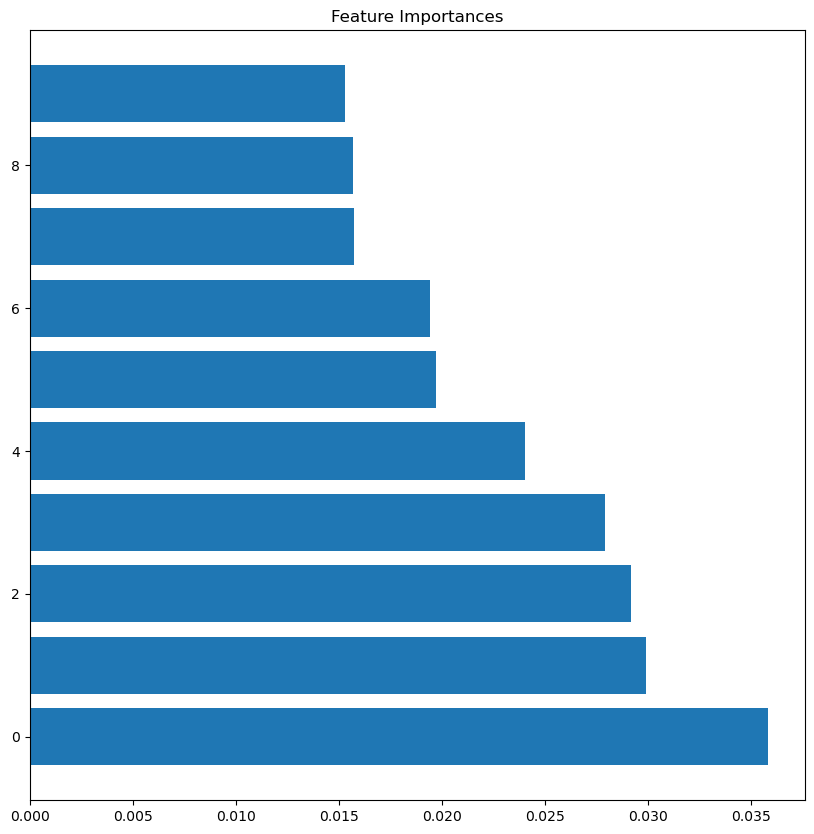

In [24]:
# 각 베이스 모델과 스태킹 모델의 예측 및 성능 평가
models = {
    'XGBoost': xgb_best_model,
    'LightGBM': lgb_best_model,
    'RandomForest': rf_best_model,
    'Stacking': stacking_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy}, Mean Squared Error: {mse}")

# 모델 저장
joblib.dump((stacking_model, scaler, X.columns), r'C:\Users\NT551\Desktop\날짜별 깃 업데이트 모음\06.19\stacking_model_draft5.pkl')

# 특성 중요도 시각화
def plot_feature_importances(model, feature_names, n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 10))
    plt.title("Feature Importances")
    plt.barh(range(n), importances[indices][:n], align="center")
    plt.yticks(range(n), np.array(feature_names)[indices][:n])
    plt.gca().invert_yaxis()
    plt.show()

# 스태킹 모델의 메타 모델 특성 중요도 시각화
print("Feature importances for the Stacking model's meta model (RandomForest):")
meta_model_feature_names = [name for name, _ in base_models]
plot_feature_importances(stacking_model.final_estimator_, meta_model_feature_names)
